In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from LB_D2Q9 import pipe_cython as lb
from LB_D2Q9 import pipe_opencl as lb_cl

We now want to visualize the evolution of the flow...let's see how it goes...

In [6]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [12]:
#### Input to the simulation in SI. ######
diameter = 1. # meters
length = 4. # meters

deltaP = -0.01

dr = 0.01
dt = dr**2

viscosity = 10.**-1. # More viscous = easier to simulate!

##### Derived parameters ######
print 'Desired viscosity:' , viscosity
#Re = (input_velocity * diameter)/viscosity
#print 'Desired Re', Re

# Re is set by diameter, input_velocity, and viscosity
# Adjust dr so that mach number doers not explode!
print
print '###### Simulation Parameters #########'
print

# Solve for the desired omega...make sure it's in the correct range.

ly = int(np.ceil(diameter/dr))
lx = int(np.ceil(length/dr))
print 'lx', lx
print 'ly', ly
nx = lx + 1
ny = ly + 1


omega = .5 + (3*dt*viscosity)/(dr**2)

print 'omega:' , omega

assert (omega > 0.5) and (omega < 1)

# U should be on the order of 0.1, 0.2 in the simulation!
#print 'u_max in simulation:' , np.max(sim.u)

Desired viscosity: 0.1

###### Simulation Parameters #########

lx 400
ly 100
omega: 0.8


In [13]:
import skimage as ski
import skimage.draw

In [14]:
import sys

In [15]:
sim = lb_cl.Pipe_Flow(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP)

2d global: (416, 128)
2d local: (32, 32)
3d global: (416, 128, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192, 8192, 8192]
---------------------------
This context is associated with  1 devices


/home/bryan/anaconda/lib/python2.7/site-packages/pyopencl/__init__.py:59: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x29f38d8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <update_feq> was successfully vectorized (8)
Kernel <update_hydro> was successfully vectorized (4)
Kernel <collide_particles> was successfully vectorized (4)
Kernel <copy_buffer> was successfully vectorized (4)
Kernel <move> was successfully vectorized (4)
Kernel <move_bcs> was successfully vectorized (4)
Kernel <set_zero_velocity_in_obstacle> was successfully vectorized (4)
Kernel <bounceback_in_obstacle> was not vectorized
Done.
  warn(text, CompilerWarning)


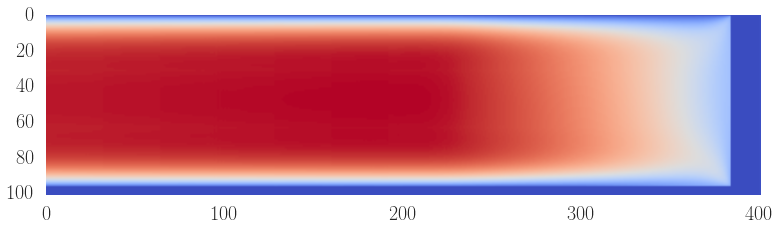

max non_dim u: 0.00721329
sum of mass 0.986097758389


In [ ]:
total_num_steps = 300
steps_per_image= 10

num_to_record = int(np.ceil(float(total_num_steps)/steps_per_image))

plt.figure()
for i in range(num_to_record):
    
    fields = sim.get_fields_on_cpu()
    u = fields['u']
    v = fields['v']
    mag = np.sqrt(u**2 + v**2)
    rho = fields['rho']
    
    print 'max non_dim u:', np.max(u)
    print 'sum of mass' , np.sum(rho)/(sim.nx*sim.ny)
    plt.imshow(mag.T, cmap = cm.coolwarm)
    plt.grid(False)
    #plt.clim(vmin=0, vmax=1.)
    #if i == 0:
    #    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_image)
plt.clf() # This way a second figure does not appear at the end...

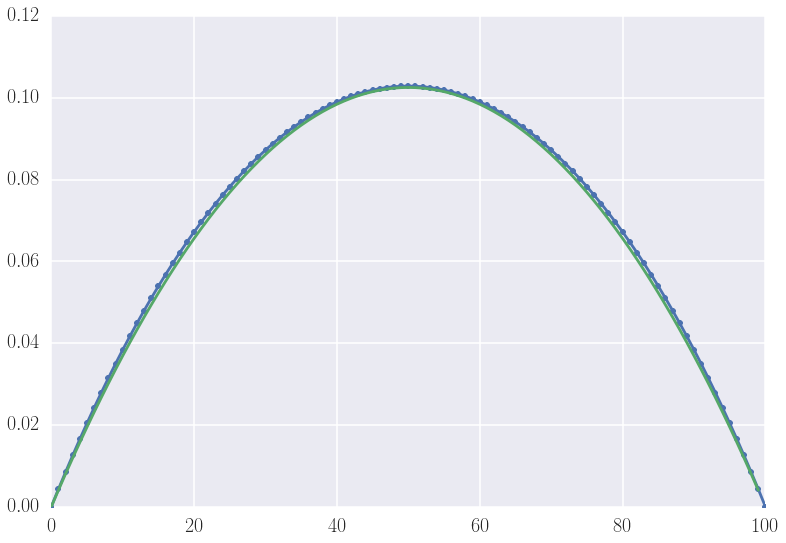

In [44]:
plt.plot(u[300, :], ls='-', marker='.')
x = np.arange(0, 100)
plt.plot(-.000041*x*(x-100))

Hm. I really don't like that we have a non-zero velocity at the wall...can we fix this? We could implement mid-point bounce-back. That is *way* more painful though, especially on the GPU, and will go way slower.

Ok this looks good. Excellent. Seemed to take a long time to converge...hopefully that's ok. At least we have something working as a baseline.

IDK how to convert...but let's just fit.

In [ ]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

In [ ]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!